# Problem Set 2, due January 23th at 5:30 pm/January 24th 3:30pm

**Please Note:** This assignment will likely take you a _long_ time, especially if you are new to Python. Start early!

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on Canvas). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from Canvas. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|---------|---------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	  |gender of head of household (male=1)|
|hohage   |age of head of household|
|age      |years old|
|folnum	  |individual id|
|village  |	village id|
|sc97	  |schooling in 1997|

---

##Part 1: Descriptive analysis

### 1.1	Summary Statistics

Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

In [1]:
#load libraries
import pandas as pd
import numpy as np
import scipy.stats as scipy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from patsy import dmatrices
#load data
pp_df= pd.read_csv('progresa_sample.csv')

In [2]:
#print
print (pp_df.shape)
print(pp_df.columns)
#print(pp_df.dtypes)
#print(pp_df.head)

(77250, 21)
Index(['year', 'sex', 'indig', 'dist_sec', 'sc', 'grc', 'fam_n', 'min_dist',
       'dist_cap', 'poor', 'progresa', 'hohedu', 'hohwag', 'welfare_index',
       'hohsex', 'hohage', 'age', 'village', 'folnum', 'grc97', 'sc97'],
      dtype='object')


In [3]:
#get rid of NA's
pp_df = pp_df.dropna()

#Print means in new table
pp_mean=pd.DataFrame(pp_df)

#drop unwanted columns
pp_mean = pp_mean.drop(pp_mean.columns[[0,17,18]], axis=1)

#get descriptive stats.
pp_mean2 = pp_mean.describe()

#flip rows and columns
pp_averages = pp_mean2.transpose()

#make it a dataframe
pp_averages = pd.DataFrame(pp_averages)

#view new df
pp_averages

#alphebetize
sum_stats = pp_averages.sort_index()
sum_stats

#drop unwanted statistics
sum_stats = sum_stats.drop(sum_stats.columns[[0, 3,4,5,6,7]], axis=1)
sum_stats


,mean,std
age,11.141369,2.995374
dist_cap,148.747707,77.134043
dist_sec,2.346990,2.111281
fam_n,7.224666,2.329421
grc,4.089494,2.447608
grc97,3.762656,2.449568
hohage,44.262224,11.457772
hohedu,2.853908,2.655106
hohsex,0.927744,0.258914
hohwag,592.782484,791.378223


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male  |?     |?     |?     |?     |


The baseline characteristics are fairly consistant when looking at the means of the treatment and control groups. 
The t-test allows us to see that min_dist, dist_cap, hohwag, welfare_index, and hohage all have low pvalues which indicates that the differences for these variables is significant.

In [4]:
# Subset to poor and 1997
poor1 = pp_df[(pp_df["poor"] == "pobre") & (pp_df["year"] == 97)]

# Treatment villages (basal) and control (0), dropping non-numeric columns
treat = poor1[poor1["progresa"] == "basal"].drop(["folnum", "village", "year", "poor", "progresa"], axis = 1)
control = poor1[poor1["progresa"] == "0"].drop(["folnum", "village", "year", "poor", "progresa"], axis = 1)



In [5]:
#create dem variables ls
dem_variables = ['sex', 'indig', 'dist_sec', 'sc', 'grc', 'fam_n', 'min_dist','dist_cap', 'hohedu', 'hohwag', 'welfare_index','hohsex', 'hohage', 'age', 'grc97', 'sc97']

#create empty data frame and store average results 
ttest_df = pd.DataFrame()
ttest_df['variable name'] = dem_variables


#find control means
control_means = control[dem_variables]
control_means = np.array(control_means.mean())

# find treatment means
treatment_means = treat[dem_variables]
treatment_means = np.array(treatment_means.mean())
control_means
treatment_means

#put means into df
ttest_df['Average Value (treatment)'] = treatment_means
ttest_df['Average Value (control)'] = control_means


#difference column
ttest_df['Difference (treat-control)'] = (treatment_means - control_means)



In [6]:

#ttest
ttest = scipy.stats.ttest_ind(treat.dropna(axis = 0), control.dropna(axis = 0)) 
ttest

#add pvalue to table
ttest_df['pvalue'] = ttest.pvalue

#check to see if it worked
#(ttest_df)

### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

A:  There are statistically significant differences between treatment and control villages as baseline. 
Min_dist, dist_cap, hohwag, welfare_index, and hohage all have pvalues lower than .05 which indicates a statistically significant difference between treatment and control.

B: The significant differences (with low p values) tell us that those variables are not significant by chance. They are not simply random. 
    
C: We will need to ensure that the variables with low p values are not impeding our ability to measure the true treatment effect, as they may be covariates masking the treatment effect.
    

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

I am noticing that the average enrollment rates for each year of hoh education has generally a slightly upward trend, but hovers between.77 and .98.
The most noticable thing, however, is that at 20 years of school for the hoh, the average enrollment plummits to around .5.

In [7]:
#filter by year
enroll_df = pp_df[pp_df.year == 97]
enroll_df

#create new df
edu_df = pd.DataFrame()
edu_df['average_enrollment'] = enroll_df.groupby('hohedu')['sc'].mean()

#print
#print(edu_df)

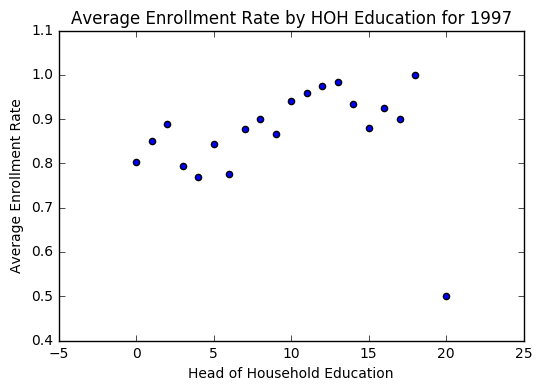

In [8]:
#create scatterplot
plt.scatter(enroll_df.hohedu.unique(), edu_df.average_enrollment)

#labels
plt.title('Average Enrollment Rate by HOH Education for 1997')
plt.ylabel('Average Enrollment Rate')
plt.xlabel('Head of Household Education')

plt.show()

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households).
* Does there appear to be a difference? Is this difference statistically significant?
* Which D estimator in Schultz (2004) does this approach correspond to?

There is a difference between average enrollment rates in treated villages from 1997-1998. The histogram shifts to the right in 1998, and consequently, so does the mean. The t test results give us a p value of .01 which means that the difference is statistically significant. This corresponds to Schultz's D1 estimator.



In [9]:
#Pull Poor and Treated 
poor_treated= pp_df[pp_df.poor == 'pobre']
poor_treated=poor_treated[poor_treated.progresa=='basal']

#Filter by year
enroll_97 = poor_treated[poor_treated.year==97]
enroll_98 = poor_treated[poor_treated.year==98]

#calculate average villiage enrollments 97
enrolled_97 = pd.DataFrame()
enrolled_97['avg_enrollment'] = enroll_97.groupby('village')['sc'].mean()

#calculate average village enrollments 98
enrolled_98 = pd.DataFrame()
enrolled_98['avg_enrollment'] = enroll_98.groupby('village')['sc'].mean()
enrolled_98

,avg_enrollment
village,
1,0.809917
2,0.714286
4,0.946058
5,0.976744
6,0.903846
7,0.875000
8,0.851852
9,0.777778
10,0.761905


In [10]:
# create enrolled_97 plot
x= np.array(enrolled_97.avg_enrollment)

#create enrolled_98 plot
x2 = np.array(enrolled_98.avg_enrollment)

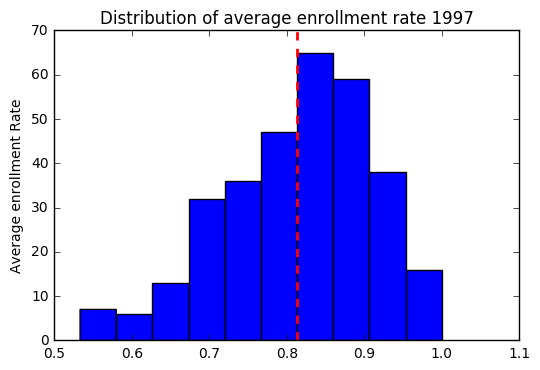

In [11]:
#plot 97 
plot_97 = plt.hist(x)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=2)

#labels
plt.title('Distribution of average enrollment rate 1997')

plt.ylabel('Average enrollment Rate')


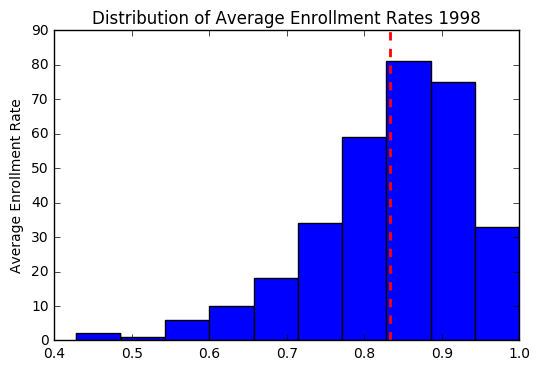

In [12]:
#plot 98
plot_98 = plt.hist(x2)
plt.axvline(x2.mean(), color='r', linestyle='dashed', linewidth=2)

#labels
plt.title('Distribution of Average Enrollment Rates 1998')
plt.ylabel('Average Enrollment Rate')


In [13]:
#Calculate significance with t test
scipy.stats.ttest_ind(x,x2,axis = 0,equal_var=True)

Ttest_indResult(statistic=-2.5636087966029333, pvalue=0.010587739721624679)

## Part 2: Measuring Impact

### 2.1 Simple differences: T-test

Start out by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment).
* calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages.
* Which difference estimator in Schultz (2004) does this approach correspond to?
* Use a t-test to determine if this difference is statistically significant. What do you conclude?

The average enrollment for poor households in treatment villages is .833. The average enrollment for poor households in control villages is .808.

This approach corresponds to the D2 difference estimator.

After doing the t-test, I found the p-value to be 0.006, which means the difference is statistically significant.

In [14]:
# filter for Poor and 1998
simp_dif= pp_df[pp_df.poor == 'pobre']
simp_dif = simp_dif[simp_dif.year==98]

#filter for Poor treatment
treated_poor_98=simp_dif[simp_dif.progresa=='basal']
treated_mean = treated_poor_98.groupby('village')['sc'].mean()
print('Average enrollment for poor households in Treatment Villages', treated_mean.mean())

#filter for Poor Control
untreated_poor_98=simp_dif[simp_dif.progresa=='0']
untreated_mean = untreated_poor_98.groupby('village')['sc'].mean()
print('Average enrollment for poor households in Control Villages', untreated_mean.mean())



Average enrollment for poor households in Treatment Villages 0.8337415033712263
Average enrollment for poor households in Control Villages 0.8086240746137184


In [15]:
#t-test
scipy.stats.ttest_ind(treated_mean, untreated_mean,axis = 0,equal_var=True)

Ttest_indResult(statistic=2.7087610827588358, pvalue=0.0069850909415748053)

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

 Treatment increased the odds of enrollment by .0388.
 
 The regression shows a much smaller estimate of impact than the ttest estimate in part 2.1, which was 2.7.
 
 The results of the regression model tell us we can reject the null hypothesis that the treament effects are 0.
 
 The counterfactual assumption underlying this regression is that without the treatment, we would have to accept the null hypothesis in expecting the treatment effect to be 0. 

In [16]:
#filter by 1998 & poor
simp_dif= pp_df[pp_df.poor == 'pobre']
simp_dif = simp_dif[simp_dif.year==98]

#create dummy variable
dummy_treatment = pd.get_dummies(simp_dif['progresa'], prefix='treatment')
print (dummy_treatment.head())

# create new df add dummies
model_df = pd.DataFrame(simp_dif).join(dummy_treatment)


#linear regression
simp_lm = smf.ols(formula = 'sc ~ treatment_basal',data=model_df).fit()
simp_lm.summary()


   treatment_0  treatment_basal
1            1                0
3            1                0
5            1                0
7            0                1
9            0                1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     65.64
Date:                Sun, 02 Jul 2017   Prob (F-statistic):           5.66e-16
Time:                        14:34:34   Log-Likelihood:                -11171.
No. Observations:               26155   AIC:                         2.235e+04
Df Residuals:                   26153   BIC:                         2.236e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.8109      0.004    217.190      0.000         0.804     0.818
treatment_basal     0.0383      0.005      8.102      0.000         0.029     0.048
==============================================================================
Omnibus:                     7487.800   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15756.374
Skew:                          -1.796   Prob(JB):                         0.00
Kurtosis:                       4.245   Cond. No.                         3.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

The controls reduce the point estimate of the treatment effect from .0388 to .0358.

The controls did not impact the standard error.  Both have SE's of .005.

The differences are so slight in the point estimates of the treatment effect, with the same standard error, which shows us that with the same amount of error,the point estimates remain very close.  Essentially, the other control variables added to the regression model didn't significantly impact either the error or the treatment effect.

In [17]:

#Multiple regression
simp_lm = smf.ols(formula = 'sc ~ treatment_basal+hohedu + hohwag +welfare_index + sex + dist_sec',data=model_df).fit()
simp_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     90.81
Date:                Sun, 02 Jul 2017   Prob (F-statistic):          2.85e-113
Time:                        14:34:42   Log-Likelihood:                -10934.
No. Observations:               26155   AIC:                         2.188e+04
Df Residuals:                   26148   BIC:                         2.194e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.8691      0.015     59.837      0.000         0.841     0.898
treatment_basal     0.0364      0.005      7.748      0.000         0.027     0.046
hohedu              0.0164      0.001     17.890      0.000         0.015     0.018
hohwag          -2.122e-06   3.24e-06     -0.655      0.513     -8.48e-06  4.23e-06
welfare_index      -0.0001      2e-05     -6.987      0.000        -0.000    -0.000
sex                 0.0254      0.005      5.577      0.000         0.016     0.034
dist_sec           -0.0093      0.001     -8.625      0.000        -0.011    -0.007
==============================================================================
Omnibus:                     7207.880   Durbin-Watson:                   1.748
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14789.037
Skew:                          -1.744   Prob(JB):                         0.00
Kurtosis:                       4.183   Cond. No.                     6.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages. The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


The estimate of impact is .03133 , which is slightly lower than simple dif. regression estimate of .0388.
The counterfactual assumption is that the treatment is the only thing impacting enrollment.

In [18]:
# filter poor 97 
simp_dif_97= pp_df[pp_df.poor == 'pobre']
simp_dif_97= simp_dif_97[simp_dif_97.year==97]

#filter treated/untreated 97
tp_97=simp_dif_97[simp_dif_97.progresa=='basal']
utp_97=simp_dif_97[simp_dif_97.progresa=='0']

#filter poor 98
simp_dif_98= pp_df[pp_df.poor == 'pobre']
simp_dif_98= simp_dif_98[simp_dif_98.year==98]

#filter treated/untreated 98
tp_98=simp_dif_98[simp_dif_98.progresa=='basal']
utp_98=simp_dif_98[simp_dif_98.progresa=='0']

In [19]:
#calculate 97 averages
treated_97_mean = tp_97['sc'].mean()


untreated_97_mean = utp_97['sc'].mean()


#calculate 98 averages
treated_98_mean = tp_98['sc'].mean()


untreated_98_mean = utp_98['sc'].mean()


print(treated_97_mean, untreated_97_mean, treated_98_mean,untreated_98_mean)



0.822696523152761 0.8150655583169081 0.849257030578411 0.810923092511906


In [20]:
#calculate diff-in-diff treatment
dif_t = treated_98_mean - treated_97_mean

#calculate diff in diff control
dif_c = untreated_98_mean - untreated_97_mean

#diff in diff
dif_dif = dif_t - dif_c

print(dif_dif)
print(dif_t,dif_c)


0.030702973230652075
0.02656050742564997 -0.004142465805002105


### 2.5 Difference-in-Difference, version 1 (regression)

Now use a regression specification to estimate the average treatment effect of the program (on the poor) in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

The estimate of the impact of Progresa can be seen in the Year:treatment_basal coefficient in the output. That number is .0307.  The standard error associated with it is extremely low at .006.  That means that with very small chance of error, we can say that the average treatment effect of the program .0307. In other words the treatment increased the likelihood of enrollment by .0307.

The simple difference calculated that the treatment effect was ever so slightly higher, and with .001 less of a standard error rate compared to these estimates.

These estimates are also slightly smaller than the difference -to-difference estimates in 2.4, where the estimate was .03133 for treatment effect.

The counterfactual assumption is that treatment would not impact enrollment.

In [21]:
temp_df = pp_df

#create dummy variable
dummy_treatment2 = pd.get_dummies(temp_df['progresa'], prefix='treatment')

# create new dfs add dummies
dum_df = pd.DataFrame(temp_df).join(dummy_treatment2)
#print(dum_df)

# Subset to poor
subset_poor = dum_df[(dum_df["poor"] == 'pobre')]




In [22]:
# Create MLR
MLR_year = smf.ols(formula = 'sc ~ year*treatment_basal + dist_sec + indig + hohedu + sex + welfare_index', data=subset_poor).fit()

#print summary
print(MLR_year.summary())


                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     160.7
Date:                Sun, 02 Jul 2017   Prob (F-statistic):          3.01e-269
Time:                        14:35:20   Log-Likelihood:                -24820.
No. Observations:               56893   AIC:                         4.966e+04
Df Residuals:                   56884   BIC:                         4.974e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                1.4168 

### 2.6 Difference-in-Difference, version 2

In the previous problem, you estimated a difference-in-differences model that compared changes in enrollment rates over time across treatment and control villages. An alternative approach would be to compare enrollment rates in 1998 between poor and non-poor across treatment and control villages. 

* How would we estimate this version of the treatment effects in a regression model? 
* What is the counterfactual assumption underlying this regression?
* How do these treatment effects compare to the estimates above?
* Discuss some possible explanations for differences or similarities 

We would estimate this version of the treatment effects by filtering for year (1998), and comparing at the treatment effect of poor and non-poor villages.

The counterfactual assumption underlying this regression is that the treatment will have a no more impact on poor villages, than on non-poor villages.

The treatment effect (measured by poor:treatment_basal) is much larger at .017, than those above.

One possible explanation for this is that in the discrepancy between enrollment in poor vs. not poor villages is much higher, therefore we would expect to see the treatment have a larger impact than it did in the previous regression (looking at treatment effect within poor villages as opposed to between poor and non-poor). 

In [23]:

# Subset to year
subset_year = dum_df[(dum_df["year"] == 98)]

# Create MLR
MLR_poor = smf.ols(formula = 'sc ~ poor*treatment_basal + dist_sec + indig + hohedu + sex + welfare_index', data=subset_year).fit()

#print summary
print(MLR_poor.summary())

                            OLS Regression Results                            
Dep. Variable:                     sc   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sun, 02 Jul 2017   Prob (F-statistic):          2.35e-167
Time:                        14:35:29   Log-Likelihood:                -13119.
No. Observations:               30665   AIC:                         2.626e+04
Df Residuals:                   30656   BIC:                         2.633e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------
Intercept     

### 2.7 Spillover effects (extra credit)

Thus far, we have focused on the impact of PROGRESA on poor households. Repeat your analysis in 2.5, using a double-difference regression to estimate the impact of PROGRESA on non-poor households. In other words, compare the difference in enrollments between 1997 and 1998 for non-poor households in treatment villages with the difference in enrollments between 1997 and 1998 for non-poor households in control villages.

* A: Describe one or two reasons why PROGRESA might have impacted non-poor households.
* B: Do you observe any impacts of PROGRESA on the non-poor?
* C: What is the identifying assumption that you are using to estimate the impact of PROGRESA on non-poor households.

### 2.8 Summary

Based on all the analysis you have undertaken to date, do you thik that Progresa had a causal impact on the enrollment rates of poor households in Mexico?

Because The beta values for the treatment effect are larger than 0, we can say that we see some evidence that Progresa had a causal impact on the enrollment rates of poor households in Mexico. 
That said, the beta is very small in all cases, which makes it seem that we have to grapple with how big does the beta need to be in order to determine whether a causal impact exists.  